# Set up

In [8]:
import numpy as np
import cv2  # Still used for image I/O and adding noise
import matplotlib.pyplot as plt
import time

# Fourier Transformation Utility Functions using NumPy
def fft2(u):
##    return np.fft.fftshift(np.fft.fft2(u))
    M,N = u.shape
    return np.fft.fft2(u)/(M)

def ifft2(u_hat):
##    return np.fft.ifft2(np.fft.ifftshift(u_hat)).real
    M,N = u_hat.shape
    return  M*np.fft.ifft2(u_hat)
    #return np.ifft2(u_hat).real

# Backward and Central Fractional Derivatives
# def back_Dx(u, alpha):
#     u_hat = fft2(u)
#     M, N = u.shape
#     w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
#     complex_term = 1 - np.exp((-1j * 2 * np.pi * w1_grid[:, None]) / M)
#     K = np.power(complex_term, alpha)
#     dx_hat = u_hat * K
#     dx = ifft2(dx_hat)
#     return dx

# def back_Dy(u, alpha):
#     u_hat = fft2(u)
#     M, N = u.shape
#     w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
#     complex_term = 1 - np.exp((-1j * 2 * np.pi * w2_grid) / N)
#     K = np.power(complex_term, alpha)
#     dy_hat = u_hat * K
#     dy = ifft2(dy_hat)
#     return dy

def _Dx(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    complex_term = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
    K = np.power(complex_term, alpha)
    dx_hat = u_hat * K
    dx = ifft2(dx_hat)
    return dx

def Dx(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    x = np.power(1 - np.exp(-1j*2*np.pi * array_x/M), alpha)
    ##K = np.power(complex_term, alpha)
    dx_hat = u_hat * x
    dx = ifft2(dx_hat)
    return dx

def _Dy(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    complex_term = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
    K = np.power(complex_term, alpha)
    dy_hat = u_hat * K
    dy = ifft2(dy_hat)
    return dy

def Dy(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    y = np.power(1 - np.exp(-1j*2*np.pi * array_y/N), alpha)
    ##K = np.power(complex_term, alpha)
    dy_hat = u_hat * y
    dy = ifft2(dy_hat)
    return dy

def Dx_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    x = np.power(1 - np.exp(-1j*2*np.pi * array_x/M), alpha)
    z = np.power(np.exp(1j*np.pi * array_x/M), alpha)
    ##K = np.power(complex_term, alpha)
    dx_hat = u_hat * x * z
    dx = ifft2(dx_hat)
    return dx

def Dy_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    y = np.power(1 - np.exp(-1j*2*np.pi * array_y/N), alpha)
    z = np.power(np.exp(1j*np.pi * array_y/M), alpha)
    ##K = np.power(complex_term, alpha)
    dy_hat = u_hat * y * z
    dy = ifft2(dy_hat)
    return dy


# Diffusion Coefficient Computation
# def C(u, alpha, beta):
#     D = np.sqrt(np.square(Dx(u, alpha)) + np.square(Dy(u, alpha)))
    # mu_nn_numerator = np.square(Dx(u, beta)) * Dx(Dx(u, beta), beta) + 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dy(Dy(u, beta), beta)
    # mu_nn_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_nn = mu_nn_numerator / mu_nn_denominator
    # mu_ee_numerator = np.square(Dx(u, beta)) * Dy(Dy(u, beta), beta) - 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dx(Dx(u, beta), beta)
    # mu_ee_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_ee = mu_ee_numerator / mu_ee_denominator
    # fDC = np.abs(np.abs(mu_nn) - np.abs(mu_ee))
#     c = 1 / (1 + D +fDC)
#     return c

def C(u, alpha, beta):
    D = (np.square(Dx_central(u, alpha)) + np.square(Dy_central(u, alpha)))
    # mu_nn_numerator = np.square(Dx_central(u, beta)) * Dx_central(Dx_central(u, beta), beta) + 2 * Dx_central(u, beta) * Dy_central(u, beta) * Dx_central(Dy_central(u, beta), beta) + np.square(Dy_central(u, beta)) * Dy_central(Dy_central(u, beta), beta)
    # mu_nn_denominator = np.square(Dx_central(u, beta)) + np.square(Dy_central(u, beta)) + 0.001
    # mu_nn = mu_nn_numerator / mu_nn_denominator
    # mu_ee_numerator = np.square(Dx_central(u, beta)) * Dy_central(Dy_central(u, beta), beta) - 2 * Dx_central(u, beta) * Dy_central(u, beta) * Dx_central(Dy_central(u, beta), beta) + np.square(Dy_central(u, beta)) * Dx_central(Dx_central(u, beta), beta)
    # mu_ee_denominator = np.square(Dx_central(u, beta)) + np.square(Dy_central(u, beta)) + 0.001
    # mu_ee = mu_ee_numerator / mu_ee_denominator
    # fDC = np.abs(np.abs(mu_nn) - np.abs(mu_ee))

    # mu_nn_numerator = np.square(Dx(u, beta)) * Dx(Dx(u, beta), beta) + 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dy(Dy(u, beta), beta)
    # mu_nn_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_nn = mu_nn_numerator / mu_nn_denominator
    # mu_ee_numerator = np.square(Dx(u, beta)) * Dy(Dy(u, beta), beta) - 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dx(Dx(u, beta), beta)
    # mu_ee_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_ee = mu_ee_numerator / mu_ee_denominator
    # fDC = np.abs(np.abs(mu_nn) - np.abs(mu_ee))
    c = 1 / (1 + D)
    return c

# Compute Kx and Ky using NumPy
# def make_K(M, N, alpha):
#     w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
#     w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
#     complex_term_x = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
#     complex_term_y = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
#     Kx = np.power(complex_term_x, alpha)
#     Ky = np.power(complex_term_y, alpha)
#     return Kx, Ky

def make_K(M, N, alpha):

    diagonal_matrix = np.diag(np.arange(M))
    identityMatrix = np.eye(M)
    #w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    #w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    #complex_term_x = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
    #complex_term_y = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
    Kx = np.power(1 - np.exp(-1j*2*np.pi * diagonal_matrix*identityMatrix/M), alpha)*np.power(np.exp(1j*np.pi * diagonal_matrix*identityMatrix/M), alpha)
    Ky = np.power(1 - np.exp(-1j*2*np.pi * diagonal_matrix*identityMatrix/M), alpha)*np.power(np.exp(1j*np.pi * diagonal_matrix*identityMatrix/M), alpha)
    return Kx, Ky

In [10]:
# Simulation Parameters
alpha = 1
dt = np.power(0.25,alpha)
beta = 1.1

# Image Loading and Noise Addition
u_clean = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
mean = 0
std = 15
noise = np.random.normal(mean, std, u_clean.shape)
u_noisy = u_clean + noise
u = u_noisy.copy()

# Compute Kx and Ky
M, N = u.shape
print(M,N)
Kx, Ky = make_K(M, N, alpha)

# Denoising Loop
i = 0
prev_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
#u_hat = np.fft.fftshift(np.fft.fft2(u))
u_hat = fft2(u)

print(u)
print(u_hat)
while True:
    i += 1
    print(f"Iteration {i}")

    print("DX CENTRAL")
    print(Dx_central(u,alpha))
    print("DY CENTRAL")
    print(Dy_central(u,alpha))

    print("Coefficient")
    c = C(u, alpha, beta)
    print(c)

    gx = c * Dx_central(u, alpha)
    gy = c * Dy_central(u, alpha)

    # gx_hat = np.fft.fftshift(np.fft.fft2(gx))
    # gy_hat = np.fft.fftshift(np.fft.fft2(gy))

    gx_hat = fft2(gx)
    gy_hat = fft2(gy)

    # Compute the combined g_hat using the conjugates of Kx and Ky
    g_hat = ((np.conj(Kx)) @ (gx_hat)) + ((np.conj(Ky)) @ (gy_hat))

    # Perform iteration
    u_hat = u_hat - g_hat * dt
    # u = np.fft.ifft2(np.fft.ifftshift(u_hat)).real
    u = ifft2(u_hat).real

    current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
    if prev_PSNR > current_PSNR or i > 5 :
        break
    else:
        prev_PSNR = current_PSNR
        u_denoised = u.copy()  # Update denoised image after the loop

220 220
[[143.72048331 142.74503344 158.50458681 ... 147.38504669 163.52024876
  137.73374323]
 [153.99533462 161.40011618 175.16263735 ... 166.02891465 170.16414996
  161.14058357]
 [177.85145693 169.67587842 157.56324686 ... 135.64435343 124.01142013
  103.42933962]
 ...
 [ 60.7268961   43.19862673  58.86004087 ...  53.6754196   76.07157929
   94.35621849]
 [ 32.44763578  68.13625862  78.31924769 ...  74.5822238  113.54564828
   90.79338724]
 [ 37.34764773  50.15101296  66.99930395 ... 114.97536673 104.07589489
   75.23418165]]
[[ 2.72914060e+04   +0.j         -4.21984811e+02+2002.74312567j
   1.29572364e+03 -943.29713836j ... -2.09345420e+02 -521.64434832j
   1.29572364e+03 +943.29713836j -4.21984811e+02-2002.74312567j]
 [-2.18057671e+01-1021.97695702j -1.35732005e+03+1300.72034739j
  -9.30135395e+02  +39.2307305j  ...  5.61894754e+02 +670.3690488j
  -2.86443964e+02 +366.4422765j   2.58350830e+01 +787.42919296j]
 [-3.91123628e+02 -166.26623279j -2.27819875e+02 -109.55372248j
   5.70

# Execution

In [5]:
# Simulation Parameters
alpha = 1.8
dt = np.power(0.25,alpha)
beta = 1.1

# Image Loading and Noise Addition
u_clean = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
mean = 0
std = 15
noise = np.random.normal(mean, std, u_clean.shape)
u_noisy = u_clean + noise
u = u_noisy.copy()

# Compute Kx and Ky
M, N = u.shape
print(M,N)
Kx, Ky = make_K(M, N, alpha)

# Denoising Loop
i = 0
prev_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
#u_hat = np.fft.fftshift(np.fft.fft2(u))
u_hat = fft2(u)

while True:
    i += 1
    print(f"Iteration {i}")

    
    c = C(u, alpha, beta)
    gx = c * Dx_central(u, alpha)
    gy = c * Dy_central(u, alpha)

    # gx_hat = np.fft.fftshift(np.fft.fft2(gx))
    # gy_hat = np.fft.fftshift(np.fft.fft2(gy))

    gx_hat = fft2(gx)
    gy_hat = fft2(gy)

    # Compute the combined g_hat using the conjugates of Kx and Ky
    g_hat = ((np.conj(Kx)) @ (gx_hat)) + ((np.conj(Ky)) @ (gy_hat))

    # Perform iteration
    u_hat = u_hat - g_hat * dt
    # u = np.fft.ifft2(np.fft.ifftshift(u_hat)).real
    u = ifft2(u_hat).real

    current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
    if prev_PSNR > current_PSNR :
        break
    else:
        prev_PSNR = current_PSNR
        u_denoised = u.copy()  # Update denoised image after the loop

220 220
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77


# Display Results

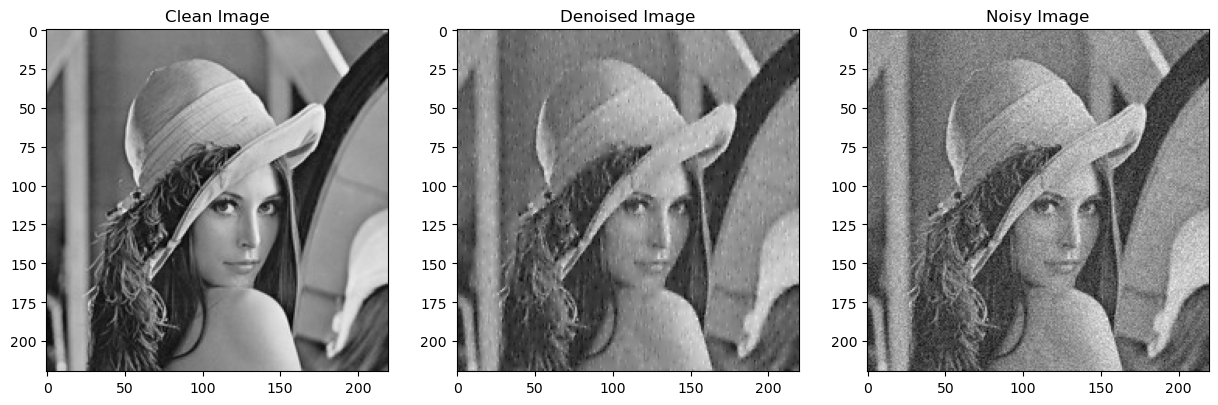

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
ax1.imshow(u_clean, cmap='gray')
ax1.set_title('Clean Image')

# Plot the denoised image
ax2.imshow(u_denoised, cmap='gray')
ax2.set_title('Denoised Image')

# Plot the noisy image
ax3.imshow(u_noisy, cmap='gray')
ax3.set_title('Noisy Image')

plt.show()

In [159]:
u_denoised - u_clean

array([[-17.96129735,  -5.91100342, -14.14682212, ...,  12.79117396,
        -18.66583471,  -5.40354037],
       [ -3.01910038,  22.09253342,   2.72762108, ..., -20.08254793,
         16.10897282, -13.4865535 ],
       [-17.4058298 ,   4.86534112,   0.52160561, ..., -20.94480154,
         -7.74080469,  -2.14492014],
       ...,
       [  1.87205839,  -1.80854731, -16.21635106, ...,   1.56250296,
          3.21843531,  24.01315277],
       [  9.28984395,   2.61535344,  -2.35885574, ...,  -6.05054171,
         -3.71338468,   6.72558086],
       [ -2.63506388,  -3.08017998,  -2.04483686, ..., -11.64557146,
          7.53183926,   2.66151737]])

In [160]:
u_noisy - u_denoised

array([[  3.73589158,   7.85681836,  14.24486384, ...,  13.1839913 ,
         17.7901231 ,   9.99769375],
       [ 13.86695396,   7.63515177,  -1.07500687, ...,  -0.32887652,
          1.48927114,  -3.4614816 ],
       [ -6.68110039, -17.83429874,  -8.68123044, ...,  13.86926881,
         -7.90223857,  -5.60716125],
       ...,
       [ -3.16116323,   3.49432778, -10.23056732, ...,  -2.22909836,
         12.11185029,  -0.47678632],
       [ -1.09930493, -25.90211502,  -4.14314502, ..., -10.19870291,
         -5.74583615,   6.14624975],
       [ -7.29623332,  -3.24469994,  -4.50496828, ...,  -1.26662629,
         -4.5171531 ,  -8.3091352 ]])

In [161]:
u_clean

array([[161, 160, 161, ..., 164, 172, 143],
       [162, 161, 161, ..., 169, 178, 149],
       [161, 160, 160, ..., 134, 121,  90],
       ...,
       [ 49,  53,  52, ...,  71,  82,  88],
       [ 45,  50,  51, ...,  87,  99,  98],
       [ 44,  50,  49, ...,  96, 106, 104]], dtype=uint8)

In [162]:
u_noisy

array([[146.77459423, 161.94581494, 161.09804172, ..., 189.97516526,
        171.12428839, 147.59415338],
       [172.84785357, 190.72768519, 162.65261421, ..., 148.58857555,
        195.59824396, 132.0519649 ],
       [136.91306981, 147.03104238, 151.84037518, ..., 126.92446727,
        105.35695675,  82.24791861],
       ...,
       [ 47.71089516,  54.68578047,  25.55308161, ...,  70.33340461,
         97.3302856 , 111.53636645],
       [ 53.19053902,  26.71323843,  44.49799924, ...,  70.75075538,
         89.54077917, 110.87183061],
       [ 34.0687028 ,  43.67512008,  42.45019486, ...,  83.08780225,
        109.01468616,  98.35238217]])

In [163]:
u_denoised

array([[143.03870265, 154.08899658, 146.85317788, ..., 176.79117396,
        153.33416529, 137.59645963],
       [158.98089962, 183.09253342, 163.72762108, ..., 148.91745207,
        194.10897282, 135.5134465 ],
       [143.5941702 , 164.86534112, 160.52160561, ..., 113.05519846,
        113.25919531,  87.85507986],
       ...,
       [ 50.87205839,  51.19145269,  35.78364894, ...,  72.56250296,
         85.21843531, 112.01315277],
       [ 54.28984395,  52.61535344,  48.64114426, ...,  80.94945829,
         95.28661532, 104.72558086],
       [ 41.36493612,  46.91982002,  46.95516314, ...,  84.35442854,
        113.53183926, 106.66151737]])